### Imports

In [16]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingClassifier
import random

random.seed(69)

In [17]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

## Leitura do ficheiro

In [18]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [19]:
# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,0.0029345,0.0000443,0.0024563,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,0.0029335,0.0001770,0.0165009,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,0.0192281,0.0002655,0.0359047,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,0.0000000,0.0000000,0.0000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,0.0044221,0.0001549,0.0100377,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [20]:
QuebrasFinal.dtypes

Código do Relatório          object
Concelho                     object
Data do incidente            object
Nível de Tensão              object
Causa do incidente           object
Duração incidente (min)      object
N.º clientes afetados       float64
TIEPI MT (min)               object
SAIFI MT (#)                 object
SAIDI MT (min)               object
END (MWh)                    object
SAIFI BT (#)                 object
SAIDI BT (min)               object
Decisão                      object
Dia                           int64
Mês                           int64
Ano                           int64
Distrito                     object
Densidade Populacional      float64
População Residente           int64
Setor Primário                int64
Setor Secundário              int64
Setor Terciário               int64
Indice de Envelhecimento    float64
Rural                       float64
T_MED                       float64
T_MAX                       float64
T_MIN                       

In [21]:
# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


## Estandardizar/Normalizar os dados

In [22]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Dia', 'Mês', 'Ano', 'Densidade Populacional',
       'População Residente', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [23]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,...,-0.466877,-1.684053,-1.009103,-0.663530,-1.766912,NaN,NaN,NaN,NaN,-0.380286
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,...,0.564873,0.703961,-1.027227,-1.174879,-1.049541,0.301675,0.351434,-0.139841,-0.598378,-0.380286
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,...,-0.870298,0.226358,-0.411014,-1.032837,0.285565,-0.177013,-0.552665,0.657334,1.193837,0.146958
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,...,2.659638,0.703961,-2.060289,-2.027127,-1.846620,-0.729344,-1.175489,0.802275,1.478315,1.715509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.052527,-0.066512,-0.028326,-0.029721,-0.028373,...,-0.630262,0.703961,-1.081598,-1.103858,-1.029614,NaN,NaN,NaN,NaN,-0.380286
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118106,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.023960,-0.208997,0.664177,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.079447,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.295818,0.075085,0.624323,NaN,NaN,NaN,NaN,0.687383
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035456,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.293405,0.703961,-0.229775,-0.180589,0.265638,-0.278273,-0.492392,-0.357252,0.226609,NaN


# EU

In [24]:
QuebrasFinal["Causa do incidente"].nunique()

24

In [25]:
QuebrasFinal['Causa do incidente'].value_counts()

Causa do incidente
Veículos                                           1213
Malfeitoria/Vandalismo                             1193
Aves                                               1134
Abate De Árvores                                    954
Escavações                                          950
Incêndio                                            466
Descarga Atmosférica Directa                        348
Furtos                                              289
Intervenções À Superficie                           168
Animais Não Aves                                    117
Corpos Estranhos Na Rede                            114
Trabalhos De Terceiros ( Gruas,... )                 83
Vento Intensidade Excepcional                        77
Risco Iminente Pessoas Ou Bens                       72
Inundações Imprevisíveis                             42
Neve/Gelo/Granizo Condição Excecional                28
Deslizamento De Terras                               25
Desabamento De Muros/Outras C

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

QuebrasFinal_causa = pd.get_dummies(QuebrasFinal, columns=['Concelho', 'Nível de Tensão'])

# Selecionando as features e o target
features = QuebrasFinal_causa.drop(['Código do Relatório', 'Causa do incidente', 'Data do incidente', 
                                    'Decisão', 'Distrito'], axis=1)
target = QuebrasFinal_causa['Causa do incidente']

# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Inicializando o classificador de árvore de decisão
clf = DecisionTreeClassifier()

# Treinando o modelo
clf.fit(X_train, y_train)

# Prevendo os valores para o conjunto de teste
y_pred = clf.predict(X_test)

# Avaliando a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print("A precisão do modelo é:", accuracy)

ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [12]:
import pandas as pd

# Suponha que você tenha um dataframe QuebrasFinal_causa com a coluna "Causa do incidente"

# Selecione as cinco principais causas
principais_causas = ['Veículos', 'Malfeitoria/Vandalismo', 'Aves', 'Abate De Árvores', 'Escavações']

# Crie variáveis dummy para as cinco principais causas
dummies = pd.get_dummies(QuebrasFinal_causa["Causa do incidente"])
dummies_principais = dummies[principais_causas]

# Crie uma coluna "Outros" somando todas as outras colunas dummy
dummies_outros = dummies.drop(columns=principais_causas)
dummies_outros['Outros'] = dummies_outros.sum(axis=1)

# Concatene as colunas das cinco principais causas com a coluna "Outros"
dummies_final = pd.concat([dummies_principais, dummies_outros['Outros']], axis=1)

# Concatene as variáveis dummy ao DataFrame original QuebrasFinal_causa
QuebrasFinal_causa_com_dummy = pd.concat([QuebrasFinal_causa, dummies_final], axis=1)

# Exiba as primeiras linhas do DataFrame final
QuebrasFinal_causa_com_dummy.head()


,Código do Relatório,Data do incidente,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),...,"Nível de Tensão_AT, MT, BT",Nível de Tensão_BT,Nível de Tensão_I,Nível de Tensão_MT,Veículos,Malfeitoria/Vandalismo,Aves,Abate De Árvores,Escavações,Outros
0,EDPD_2018_JAN_T_1,2018-01-02,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,-0.027949,-0.021644,...,False,False,False,True,False,False,False,False,True,0
1,EDPD_2018_JAN_T_2,2018-01-02,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,-0.027953,-0.027700,...,False,False,False,True,False,False,False,True,False,0
2,EDPD_2018_JAN_T_3,2018-01-04,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,0.042431,0.001999,...,False,False,False,True,False,False,False,False,False,1
3,EDPD_2018_JAN_T_4,2018-01-05,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,-0.040624,-0.037415,...,False,True,False,False,True,False,False,False,False,0
4,EDPD_2018_JAN_T_5,2018-01-09,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,-0.021523,-0.032763,...,False,False,False,True,False,False,True,False,False,0


## Imputação dos dados

In [26]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal


/usr/local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,...,-0.466877,-1.684053,-1.009103,-0.663530,-1.766912,-0.170715,-0.001784,-0.139797,-0.094998,-0.380286
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,...,0.564873,0.703961,-1.027227,-1.174879,-1.049541,0.301675,0.351434,-0.139841,-0.598378,-0.380286
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,...,-0.870298,0.226358,-0.411014,-1.032837,0.285565,-0.177013,-0.552665,0.657334,1.193837,0.146958
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,...,2.659638,0.703961,-2.060289,-2.027127,-1.846620,-0.729344,-1.175489,0.802275,1.478315,1.715509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.052527,-0.066512,-0.028326,-0.029721,-0.028373,...,-0.630262,0.703961,-1.081598,-1.103858,-1.029614,-0.290553,-0.263786,-0.217849,-0.319109,-0.380286
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118106,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.023960,-0.208997,0.664177,-0.149299,-0.107256,-0.271951,-0.228287,0.355803
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.079447,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.295818,0.075085,0.624323,-0.141388,-0.111701,-0.262819,-0.069782,0.687383
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035456,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.293405,0.703961,-0.229775,-0.180589,0.265638,-0.278273,-0.492392,-0.357252,0.226609,0.601223


# Prever causa do incidente

In [30]:
QuebrasFinal['Causa do incidente'].value_counts()

Causa do incidente
Veículos                                           1213
Malfeitoria/Vandalismo                             1193
Aves                                               1134
Abate De Árvores                                    954
Escavações                                          950
Incêndio                                            466
Descarga Atmosférica Directa                        348
Furtos                                              289
Intervenções À Superficie                           168
Animais Não Aves                                    117
Corpos Estranhos Na Rede                            114
Trabalhos De Terceiros ( Gruas,... )                 83
Vento Intensidade Excepcional                        77
Risco Iminente Pessoas Ou Bens                       72
Inundações Imprevisíveis                             42
Neve/Gelo/Granizo Condição Excecional                28
Deslizamento De Terras                               25
Desabamento De Muros/Outras C

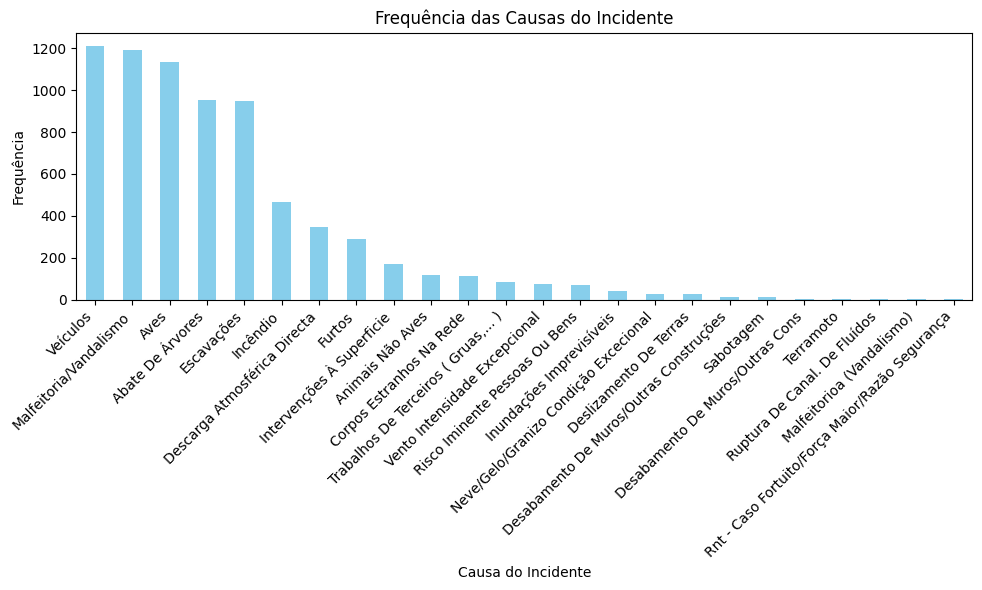

In [31]:
# Calcula as frequências das causas do incidente
frequencias = QuebrasFinal['Causa do incidente'].value_counts()

# Ordena as frequências em ordem decrescente
frequencias = frequencias.sort_values(ascending=False)

# Cria o gráfico de barras
plt.figure(figsize=(10, 6))
frequencias.plot(kind='bar', color='skyblue')
plt.xlabel('Causa do Incidente')
plt.ylabel('Frequência')
plt.title('Frequência das Causas do Incidente')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.tight_layout()  # Ajusta o layout para evitar corte de informações
plt.show()

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

QuebrasFinal_causa = pd.get_dummies(QuebrasFinal, columns=['Concelho', 'Nível de Tensão'])

# Selecionando as features e o target
features = QuebrasFinal_causa.drop(['Código do Relatório', 'Causa do incidente', 'Data do incidente', 
                                    'Decisão', 'Distrito'], axis=1)
target = QuebrasFinal_causa['Causa do incidente']

# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Inicializando o classificador de árvore de decisão
clf = DecisionTreeClassifier()

# Treinando o modelo
clf.fit(X_train, y_train)

# Prevendo os valores para o conjunto de teste
y_pred = clf.predict(X_test)

# Avaliando a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print("A precisão do modelo é:", accuracy)

A precisão do modelo é: 0.37440109514031483


In [28]:
import pandas as pd

# Suponha que você tenha um dataframe QuebrasFinal_causa com a coluna "Causa do incidente"

# Selecione as cinco principais causas
principais_causas = ['Veículos', 'Malfeitoria/Vandalismo', 'Aves', 'Abate De Árvores', 'Escavações']

# Crie variáveis dummy para as cinco principais causas
dummies = pd.get_dummies(QuebrasFinal_causa["Causa do incidente"])
dummies_principais = dummies[principais_causas]

# Crie uma coluna "Outros" somando todas as outras colunas dummy
dummies_outros = dummies.drop(columns=principais_causas)
dummies_outros['Outros'] = dummies_outros.sum(axis=1)

# Concatene as colunas das cinco principais causas com a coluna "Outros"
dummies_final = pd.concat([dummies_principais, dummies_outros['Outros']], axis=1)

# Concatene as variáveis dummy ao DataFrame original QuebrasFinal_causa
QuebrasFinal_causa_com_dummy = pd.concat([QuebrasFinal_causa, dummies_final], axis=1)

# Exiba as primeiras linhas do DataFrame final
QuebrasFinal_causa_com_dummy.head()

,Código do Relatório,Data do incidente,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),...,"Nível de Tensão_AT, MT, BT",Nível de Tensão_BT,Nível de Tensão_I,Nível de Tensão_MT,Veículos,Malfeitoria/Vandalismo,Aves,Abate De Árvores,Escavações,Outros
0,EDPD_2018_JAN_T_1,2018-01-02,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,-0.027949,-0.021644,...,False,False,False,True,False,False,False,False,True,0
1,EDPD_2018_JAN_T_2,2018-01-02,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,-0.027953,-0.027700,...,False,False,False,True,False,False,False,True,False,0
2,EDPD_2018_JAN_T_3,2018-01-04,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,0.042431,0.001999,...,False,False,False,True,False,False,False,False,False,1
3,EDPD_2018_JAN_T_4,2018-01-05,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,-0.040624,-0.037415,...,False,True,False,False,True,False,False,False,False,0
4,EDPD_2018_JAN_T_5,2018-01-09,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,-0.021523,-0.032763,...,False,False,False,True,False,False,True,False,False,0


In [33]:
features = QuebrasFinal_causa_com_dummy.drop(['Código do Relatório', 'Causa do incidente', 'Data do incidente',
                                    'Decisão', 'Distrito'], axis=1)

target = QuebrasFinal_causa_com_dummy['Causa do incidente']

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Inicialize e treine o modelo de árvore de decisão
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Faça previsões no conjunto de teste
predictions = model.predict(X_test)

# Avalie a precisão do modelo
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8590006844626967


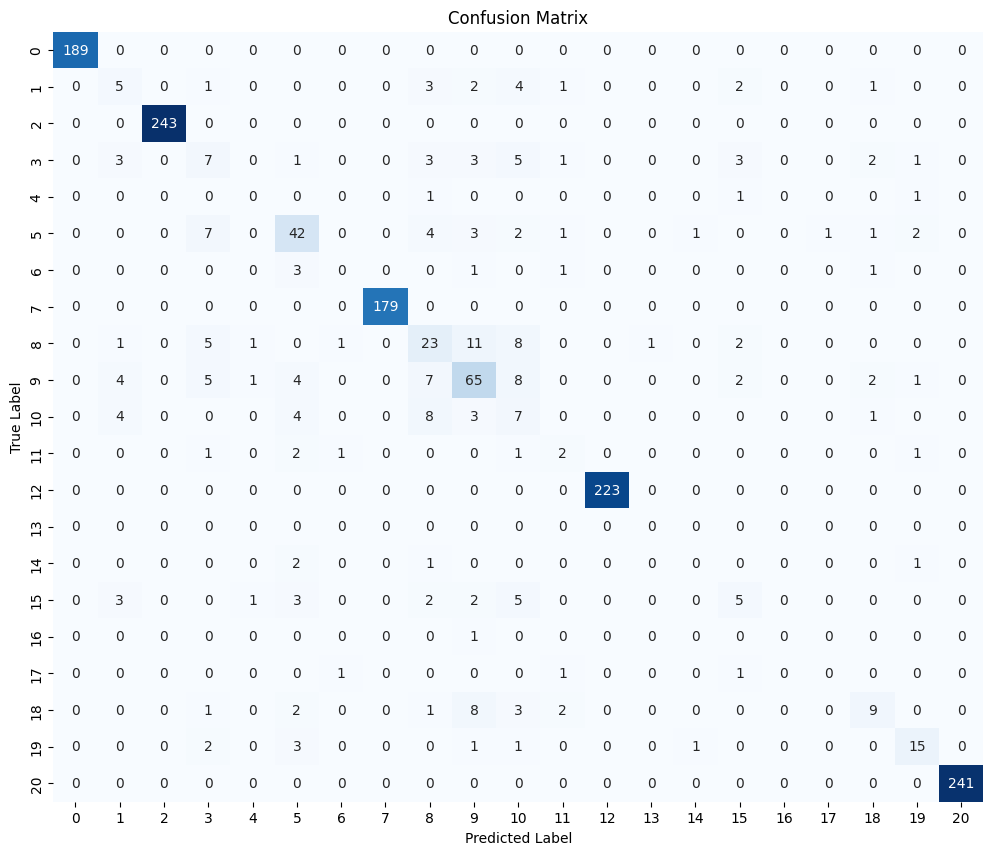

In [34]:
conf_matrix = confusion_matrix(y_test, predictions)

# Plota a matriz de confusão como um heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --

In [ ]:
QuebrasFinal["Data do incidente"] = pd.to_datetime(QuebrasFinal["Data do incidente"])
BT = QuebrasFinal[(QuebrasFinal["Distrito"] == "Lisboa")]
BT.drop(["Nível de Tensão", "TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)"], axis = 1, inplace=True)
BT

In [ ]:
BT.columns

In [ ]:
# Selecionar apenas as colunas relevantes
features = ['T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']
target = 'SAIDI BT (min)'
X = BT[features].values
y = BT[target].values

# Preparar os dados em sequências
def create_sequences(X, y, time_steps=7):
    X_sequence, y_sequence = [], []
    for i in range(len(X) - time_steps):
        X_sequence.append(X[i:i+time_steps])
        y_sequence.append(y[i+time_steps])
    return np.array(X_sequence), np.array(y_sequence)

time_steps = 1  # Janela de tempo de x dias
X_seq, y_seq = create_sequences(X, y, time_steps)

# Dividir os dados em conjuntos de treinamento e teste
split_ratio = 0.8
split = int(split_ratio * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular o Erro Percentual Absoluto Médio (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calcular o Coeficiente de Determinação (R²)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-squared (R²): {r2}')


In [ ]:
# Plotar as previsões vs. os valores reais
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('SAIDI BT (min)')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMindica')
plt.show()


In [ ]:
BT.columns

- - -

## Teste 2 (Nº Eventos) --

In [ ]:
file = data_folder / "AllDaysEventos.parquet"
QuebrasFinal = pd.read_parquet(file)
QuebrasFinal

In [ ]:
QuebrasFinal["Distrito"].unique()

In [ ]:
Concelho = 'Lisboa'

BT = QuebrasFinal[(QuebrasFinal["Distrito"] == Concelho) & (QuebrasFinal["Ano"] == 2018)]
BT = BT_grouped = BT.groupby(['Data do incidente', 'Dia', 'Mês', 'Ano', 
                               'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']).agg({'Número de Eventos': 'sum'}).reset_index()

# Não está a dar os 365 dias não sei porquê
BT

## Estandardizar/Normalizar os dados

In [ ]:
# Selecionar as colunas numéricas
colunas_numericas = BT.select_dtypes(include=[np.number]).columns
colunas_numericas

## Imputação dos dados

In [ ]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
BT[colunas_numericas] = imputer_mice.fit_transform(BT[colunas_numericas])

# Resultado final
BT


In [ ]:
BT["Número de Eventos"].unique()

In [ ]:
BT.columns

In [ ]:
# Selecionar apenas as colunas relevantes
features = ['Dia', 'Mês', 'Ano', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']
target = 'Número de Eventos'
X = BT[features].values
y = BT[target].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calcular a proporção de classes
class_weights = len(y_train) / (5 * np.bincount(y_train.astype(int)))

# Definir a função de peso de amostra
def sample_weight_function(y):
    return class_weights[y.astype(int)]

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1, sample_weight=sample_weight_function(y_train))

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

In [ ]:
# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


In [ ]:
# Plotar as previsões vs. os valores reais
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcount')
plt.show()


In [ ]:
count_eventos = BT['Número de Eventos'].value_counts()
print(count_eventos)


In [ ]:
# Selecionar apenas as colunas relevantes
data = BT[['Número de Eventos', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']]

# Dividir os dados em conjunto de treinamento e teste
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Ajustar o modelo SARIMA
order = (1, 0, 0)  # Ordem dos termos autoregressivos (AR), diferenciação (I) e média móvel (MA)
seasonal_order = (1, 0, 0, 12)  # Ordem dos termos sazonais SAR, diferenciação (I) e média móvel (SMA), e periodicidade sazonal
model = SARIMAX(train_data['Número de Eventos'], exog=train_data.drop(columns=['Número de Eventos']), order=order, seasonal_order=seasonal_order)
sarima_result = model.fit()

# Fazer previsões
predictions = sarima_result.get_forecast(steps=len(test_data), exog=test_data.drop(columns=['Número de Eventos']))
predicted_values = predictions.predicted_mean
actual_values = test_data['Número de Eventos']

# Avaliar o modelo
mse = mean_squared_error(actual_values, predicted_values)
print(f'Mean Squared Error (MSE): {mse}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Plotar as previsões
plt.plot(actual_values.index, actual_values, label='Actual')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Número de Eventos')
plt.title('Previsões SARIMA')
plt.show()

## Teste 3 (Classificação) --

In [ ]:
file = data_folder / "AllDaysEventos.parquet"
QuebrasFinal = pd.read_parquet(file)
QuebrasFinal

In [ ]:
QuebrasFinal = QuebrasFinal[(QuebrasFinal["Distrito"] == "Lisboa")]

In [ ]:
def existeEvento(x):
    if x > 0:
        return 1
    else:
        return 0

QuebrasFinal["HouveEventos?"] = QuebrasFinal["Número de Eventos"].apply(existeEvento)
QuebrasFinal.drop('Número de Eventos', axis = 1, inplace=True)
QuebrasFinal

## Estandardizar/Normalizar os dados

In [ ]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas = colunas_numericas.drop("HouveEventos?")
colunas_numericas

In [ ]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

## Imputação dos dados

In [ ]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

In [ ]:
QuebrasFinal["HouveEventos?"].unique()

In [ ]:
QuebrasFinal.columns

In [ ]:
colunas_numericas

In [ ]:
colunas_variaveis = colunas_numericas.tolist()
colunas_variaveis.append('HouveEventos?')
colunas_variaveis

In [ ]:
correlation_matrix = QuebrasFinal[colunas_variaveis].corr()
# Passo 5: Plotar um gráfico de correlações
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.savefig("Matriz de Correlação")
plt.show()

### Original

In [ ]:
# Passo 2: Dividir os dados em conjuntos de treino e teste
X = QuebrasFinal.drop(columns=['HouveEventos?', 'Data do incidente', 'Concelho', 'Distrito', 'Nível de Tensão'])
y = QuebrasFinal['HouveEventos?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 3: Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

In [ ]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

In [ ]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.savefig("OGimportanciaVariaveis")
plt.show()


In [ ]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("OGconfusionMatrix")
plt.show()


### Oversampling

In [ ]:
QuebrasFinal = QuebrasFinal[colunas_variaveis]

In [ ]:
# Separar as classes minoritárias e maioritárias
minor_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 1]
major_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 0]

# Fazer oversampling da classe minoritária
oversampled_minor_class = resample(minor_class, replace=True, n_samples=len(major_class), random_state=42)

# Juntar os dados da classe maioritária com a classe minoritária oversampled
oversampled_data = pd.concat([major_class, oversampled_minor_class])

# Separar as features (X) e o target (y)
X = oversampled_data.drop(columns=['HouveEventos?'])
y = oversampled_data['HouveEventos?']


In [ ]:
oversampled_data

In [ ]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

In [ ]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

In [ ]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.savefig("OVERimportanciaVariaveis")
plt.show()


In [ ]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("OVERconfusionMatrix")
plt.show()

In [ ]:
conf_matrix

### Undersampling

In [ ]:
# Separar as classes minoritárias e maioritárias
minor_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 1]
major_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 0]

# Fazer undersampling da classe maioritária
undersampled_major_class = resample(major_class, replace=False, n_samples=len(minor_class), random_state=42)

# Juntar os dados da classe maioritária com a classe minoritária
undersampled_data = pd.concat([minor_class, undersampled_major_class])

# Separar as features (X) e o target (y)
X = undersampled_data.drop(columns=['HouveEventos?'])
y = undersampled_data['HouveEventos?']


In [ ]:
undersampled_data

In [ ]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

In [ ]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

In [ ]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


In [ ]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()